# **Human Activity Recognition (HAR) Modeling and Feature Comparison**

#### In this notebook I did the following works:
#### 1. **Preprocess and Explore the Data:**
    - Load raw inertial sensor data from the UCI HAR dataset.
    - Visualize sample signals and class distributions.
    - Normalize the raw signals (per channel) using training set statistics.
#### 2. **Deep Learning Models on Raw Data:**
    - Build and train an improved 1D CNN model and an LSTM model.
    - Evaluate their performance (accuracy, confusion matrices, training history).
#### 3. **Machine Learning Models on Engineered Features:**
    - Extract features using TSFEL.
    - Note: I observed that some TSFEL features produce NaN values due to the short signal length. I fixed this using a SimpleImputer.
    - Load the original precomputed (561-dimensional) features provided by the authors.
    - Train ML classifiers (Random Forest, SVM, Logistic Regression) on both feature sets. 
#### 4. **Comparison Analysis:**
    - Compare model performance between TSFEL-generated features and original features.
    - Summarize results in tables and bar plots. 
**Note:** The DL models are trained solely on raw inertial sensor data, as specified.


### **Activity Labels:**
| Numeric (0-indexed) | Activity            |
|---------------------|---------------------|
| 0                   | WALKING             |
| 1                   | WALKING_UPSTAIRS    |
| 2                   | WALKING_DOWNSTAIRS  |
| 3                   | SITTING             |
| 4                   | STANDING            |
| 5                   | LAYING              |

## **1. Import Libraries and Define Helper Functions**

In [ ]:
import os  # For handling file paths and directories
import numpy as np  # For numerical operations
import pandas as pd  # For data handling and manipulation
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns  # For statistical data visualization

# Deep Learning libraries
from tensorflow.keras.models import Sequential  # To create a sequential deep learning model
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D, Flatten, BatchNormalization, Input  # Various layers for CNN and LSTM models
from tensorflow.keras.utils import to_categorical  # For one-hot encoding target labels
from tensorflow.keras.callbacks import EarlyStopping  # To prevent overfitting by stopping early

# Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier  # Random Forest model
from sklearn.svm import SVC  # Support Vector Machine model
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay  # Performance evaluation metrics
from sklearn.impute import SimpleImputer  # Handling missing values

import tsfel  # Library for extracting time-series features
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

In [ ]:
# Defining activity labels for interpretation
activity_labels = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING"
}

### **Data Loading Functions**
    - These functions load raw inertial signals (from the "Inertial Signals" subfolder) and labels.


In [ ]:
# Function to load a single file and return its contents as a numpy array
def load_file(filepath):
    # Loading a whitespace-delimited file as a numpy array.
    return pd.read_csv(filepath, header=None, delim_whitespace=True).values

# Function to load multiple files and stack them to create a 3D dataset
def load_group(filenames, prefix=''):
    # Loading a list of files (each representing one sensor channel) and stack them into a 3D array:
    # (samples, timesteps, channels).
    loaded = [load_file(os.path.join(prefix, f)) for f in filenames]
    return np.dstack(loaded)

# Function to load the dataset
def load_dataset_group(group, base_path='dataset/UCI_HAR_Dataset/UCI_HAR_Dataset'):
    # Load raw sensor data and labels for a given group (train or test).
    files = [
        f'Inertial Signals/body_acc_x_{group}.txt',
        f'Inertial Signals/body_acc_y_{group}.txt',
        f'Inertial Signals/body_acc_z_{group}.txt',
        f'Inertial Signals/body_gyro_x_{group}.txt',
        f'Inertial Signals/body_gyro_y_{group}.txt',
        f'Inertial Signals/body_gyro_z_{group}.txt',
        f'Inertial Signals/total_acc_x_{group}.txt',
        f'Inertial Signals/total_acc_y_{group}.txt',
        f'Inertial Signals/total_acc_z_{group}.txt'
    ]
    group_path = os.path.join(base_path, group)
    X = load_group(files, prefix=group_path)
    y = load_file(os.path.join(base_path, group, f'y_{group}.txt')).ravel() - 1
    return X, y

### **Load Precomputed (Original) Features**
    - These functions load the original 561-dimensional feature vectors provided by the authors.


In [ ]:
def load_precomputed_features(group, base_path='UCI HAR Dataset/UCI HAR Dataset'):
    X = pd.read_csv(os.path.join(base_path, group, f'X_{group}.txt'), delim_whitespace=True, header=None).values
    y = pd.read_csv(os.path.join(base_path, group, f'y_{group}.txt'), delim_whitespace=True, header=None).values.ravel() - 1
    return X, y

## **2. Data Loading and Exploration**

### **Load the raw sensor data and inspect shapes, distributions, and sample signals.**

In [ ]:
base_path = 'UCI HAR Dataset/UCI HAR Dataset'
X_train, y_train = load_dataset_group('train', base_path)
X_test, y_test = load_dataset_group('test', base_path)

print(f"X_train shape: {X_train.shape}")  # (samples, 128, 9)
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")    
print(f"y_test shape: {y_test.shape}")

X_train shape: (7352, 128, 9)
y_train shape: (7352,)
X_test shape: (2947, 128, 9)
y_test shape: (2947,)


### **Class Distribution Visualization (Train Set)**

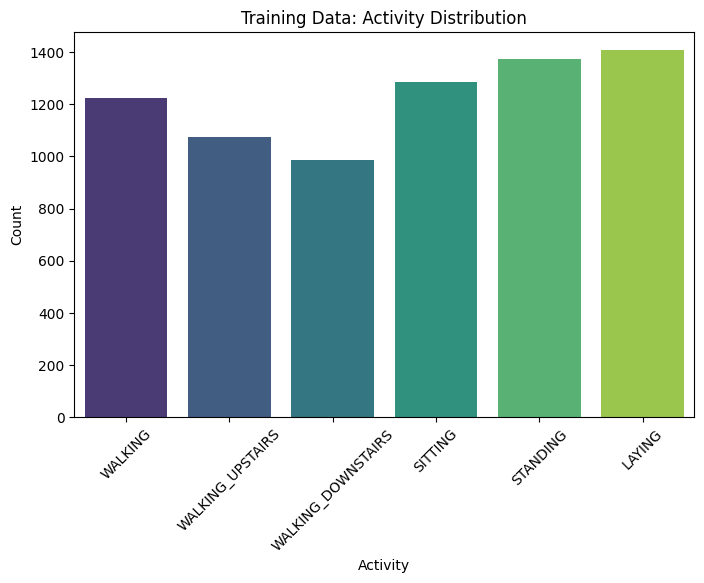

In [ ]:
y_train_named = pd.Series(y_train).map(activity_labels)
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_named, palette="viridis", order=list(activity_labels.values()))
plt.title("Training Data: Activity Distribution")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### **Sample Time-Series Visualization**
    - Plotting sample sensor signals for one window and display the corresponding activity label.


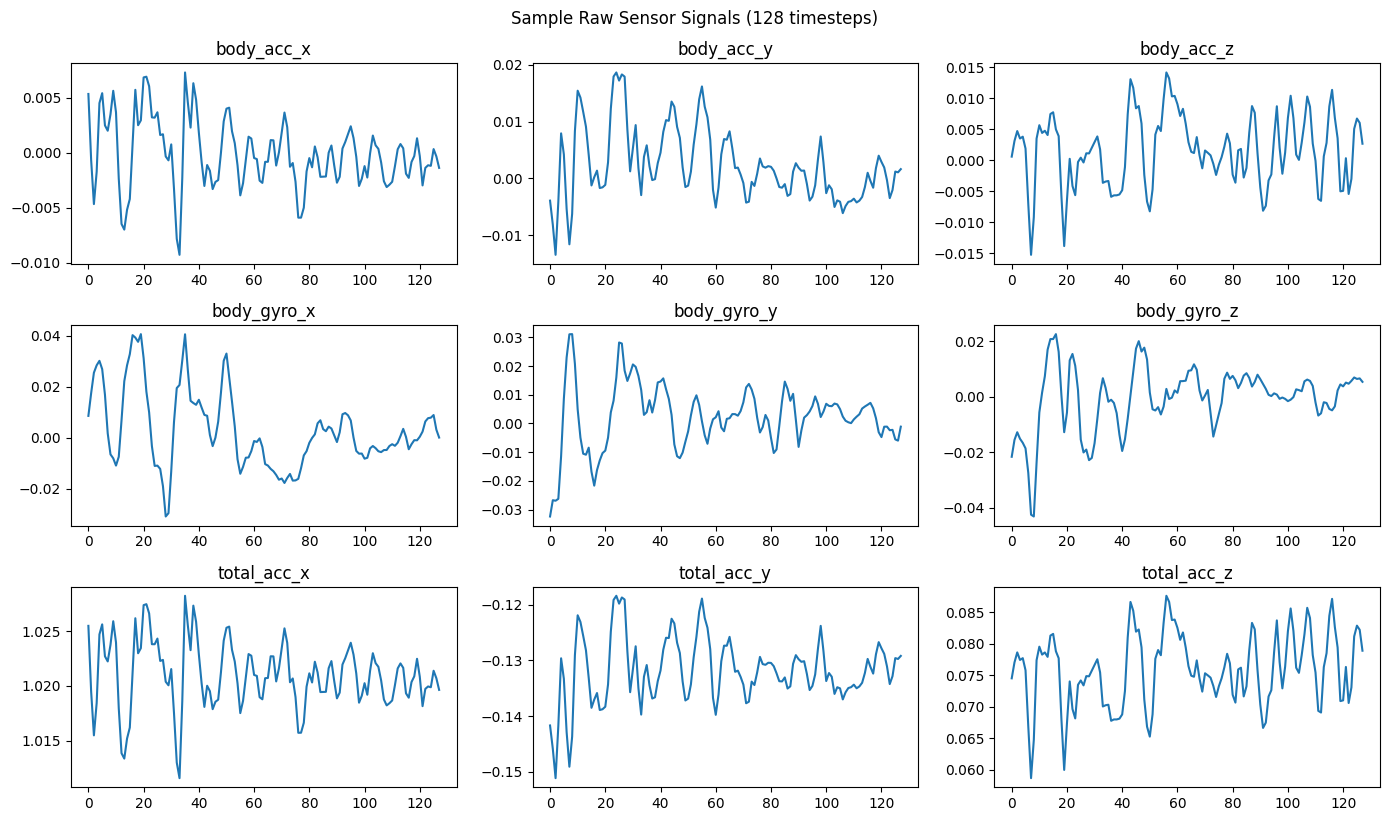

In [ ]:
sample_idx = 10  # Choosing the 10th sample from the training dataset
sample = X_train[sample_idx]  # Extract the selected sample's sensor data

# Define sensor channel names for better understanding of the plotted signals
channels = ['body_acc_x', 'body_acc_y', 'body_acc_z',  # Body acceleration in X, Y, Z axes
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z',  # Gyroscope data in X, Y, Z axes
            'total_acc_x', 'total_acc_y', 'total_acc_z']  # Total acceleration in X, Y, Z axes

plt.figure(figsize=(14, 8))
for i in range(sample.shape[1]):
    plt.subplot(3, 3, i+1)  # Arrange the plots in a 3x3 grid
    plt.plot(sample[:, i])  # Plot time-series data for the current channel
    plt.title(channels[i])  # Set title for each subplot corresponding to the sensor channel
    plt.tight_layout()  # Adjust layout to avoid overlapping plots
plt.suptitle("Sample Raw Sensor Signals (128 timesteps)", y=1.02)
plt.show()

### Preprocessing: Normalize Raw Sensor Data 



In [ ]:
# This Function Normalize each channel using training data statistics.
def normalize_data(X_train, X_test):
    X_train_reshaped = X_train.reshape(-1, X_train.shape[2])  # Reshape to 2D for mean/std computation
    means = np.mean(X_train_reshaped, axis=0)  # Compute mean per channel
    stds = np.std(X_train_reshaped, axis=0)  # Compute standard deviation per channel
    X_train_norm = (X_train - means) / stds  # Normalize training data
    X_test_norm = (X_test - means) / stds  # Normalize test data using training statistics
    return X_train_norm, X_test_norm

X_train_norm, X_test_norm = normalize_data(X_train, X_test)

## 3. Deep Learning Models on Raw (Normalized) Data
    Build and train improved deep learning models: an enhanced 1D CNN and an LSTM.

### 3.1 Improved 1D CNN Model

In [ ]:
# Function to build a 1D CNN model for feature extraction and classification
def build_cnn_model(input_shape, num_classes):
    model = Sequential()  # Initialize a sequential model
    model.add(Input(shape=input_shape))  # Define input shape (timesteps, features)
    
    # First convolutional layer with 64 filters, kernel size of 3, and ReLU activation
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())  # Normalize activations to improve training stability
    
    # Second convolutional layer to extract more complex features
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))  # Reduce spatial dimensions while retaining important information
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    
    # Third convolutional layer with increased filters (128) for deeper feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())  # Normalize to stabilize training
    model.add(MaxPooling1D(pool_size=2))  # Further reduce dimensionality
    
    # Flatten layer to convert 2D feature maps into a 1D vector
    model.add(Flatten())
    
    # Fully connected dense layer with 100 neurons and ReLU activation
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to further reduce overfitting
    
    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model using categorical crossentropy loss and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# One-hot encode the labels for categorical classification
y_train_cat = to_categorical(y_train)  # Convert training labels
y_test_cat = to_categorical(y_test)  # Convert test labels

# Build the CNN model with appropriate input shape and number of output classes
cnn_model = build_cnn_model(input_shape=(X_train_norm.shape[1], X_train_norm.shape[2]),
                            num_classes=y_train_cat.shape[1])

# Display the model architecture
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449,922 (1.72 MB)

 Trainable params: 449,538 (1.71 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:

# def build_cnn_model(input_shape, num_classes):
#     model = Sequential()
#     model.add(Input(shape=input_shape))
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
#     model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(Dense(100, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# # One-hot encode labels
# y_train_cat = to_categorical(y_train)
# y_test_cat = to_categorical(y_test)

# cnn_model = build_cnn_model(input_shape=(X_train_norm.shape[1], X_train_norm.shape[2]),
#                             num_classes=y_train_cat.shape[1])
# cnn_model.summary()


### Train 1D CNN Model

In [ ]:
# Implement early stopping to prevent overfitting
early_stop_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# - Monitors validation loss and stops training if it doesn't improve for 3 consecutive epochs
# - Restores the best model weights from before training stopped

# Train the CNN model
history_cnn = cnn_model.fit(
    X_train_norm,  # Training data (normalized sensor values)
    y_train_cat,  # One-hot encoded labels
    epochs=30,  # Maximum number of training epochs
    batch_size=64,  # Number of samples per gradient update
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[early_stop_cnn],  # Apply early stopping to avoid overfitting
    verbose=1  # Display progress during training
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6406 - loss: 1.2344 - val_accuracy: 0.4793 - val_loss: 2.1859
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8982 - loss: 0.2499 - val_accuracy: 0.5343 - val_loss: 2.7090
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9341 - loss: 0.1600 - val_accuracy: 0.7743 - val_loss: 1.2355
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9393 - loss: 0.1380 - val_accuracy: 0.8722 - val_loss: 0.9704
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9502 - loss: 0.1123 - val_accuracy: 0.9273 - val_loss: 0.9241
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9502 - loss: 0.1113 - val_accuracy: 0.8797 - val_loss: 0.9566
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9496 - loss: 0.1234 - val_accuracy: 0.9361 - val_loss: 0.8819
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9573 - loss: 0.0987 - val_accuracy: 0.9354 - v

In [ ]:

# early_stop_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# history_cnn = cnn_model.fit(X_train_norm, y_train_cat, epochs=30, batch_size=64, 
#                             validation_split=0.2, callbacks=[early_stop_cnn], verbose=1)


### Plot CNN Training History

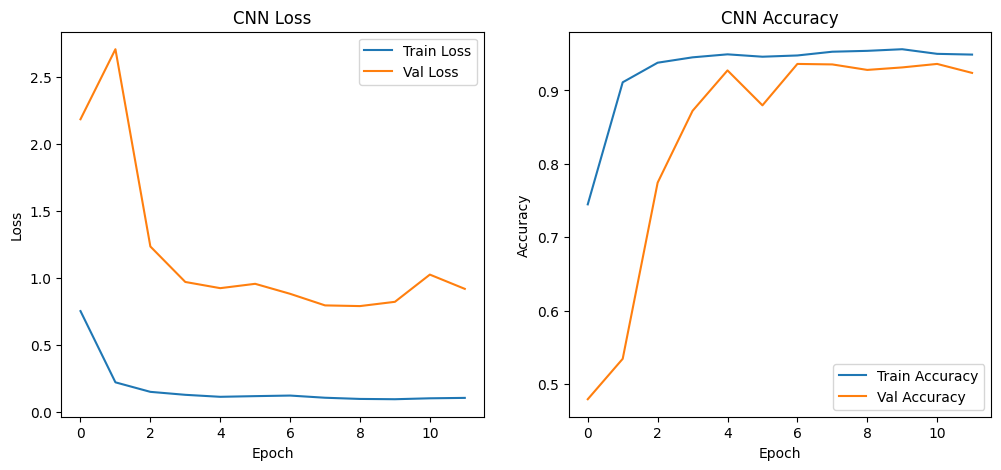

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Evaluate 1D CNN Model on Test Data and Plot Confusion Matrix

1D CNN Test Accuracy: 0.9318
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Figure size 800x600 with 0 Axes>

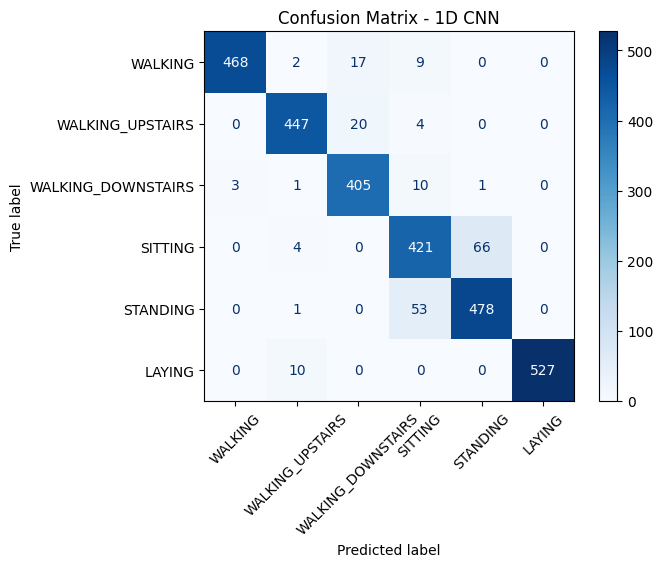

In [ ]:
# Evaluate the trained CNN model on the test dataset
loss_cnn, acc_cnn = cnn_model.evaluate(X_test_norm, y_test_cat, verbose=0)  # Compute test loss and accuracy
print(f"1D CNN Test Accuracy: {acc_cnn:.4f}")  # Print the final test accuracy

# Predict class labels for the test set
y_pred_cnn = np.argmax(cnn_model.predict(X_test_norm), axis=1)  # Convert probabilities to class labels

# Compute confusion matrix to analyze model performance
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# Initialize a plot for the confusion matrix
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn,  # Provide computed confusion matrix
                              display_labels=list(activity_labels.values()))  # Use activity names as labels
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - 1D CNN")
plt.xticks(rotation=45)
plt.show()


### 3.2 Improved LSTM Model

In [ ]:

# Function to build an LSTM model for sequential data classification
def build_lstm_model(input_shape, num_classes):
    model = Sequential()  # Initialize a sequential model
    model.add(Input(shape=input_shape))  # Define input shape (timesteps, features)
    
    # First LSTM layer with 128 units, returning sequences to pass to the next LSTM layer
    model.add(LSTM(128, return_sequences=True))  
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    
    # Second LSTM layer with 64 units, processing final sequence representation
    model.add(LSTM(64))  
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    
    # Fully connected dense layer with 100 neurons and ReLU activation for feature extraction
    model.add(Dense(100, activation='relu'))  
    
    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))  
    
    # Compile the model using categorical crossentropy loss and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build the LSTM model with appropriate input shape and number of output classes
lstm_model = build_lstm_model(input_shape=(X_train_norm.shape[1], X_train_norm.shape[2]),
                              num_classes=y_train_cat.shape[1])

# Display the model architecture
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,170 (496.76 KB)

 Trainable params: 127,170 (496.76 KB)

 Non-trainable params: 0 (0.00 B)

### Train LSTM Model

In [ ]:
# Implement early stopping to prevent overfitting
early_stop_lstm = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# - Monitors validation loss and stops training if it does not improve for 5 consecutive epochs
# - Restores the best model weights from before training stopped

# Train the LSTM model
history_lstm = lstm_model.fit(
    X_train_norm,  # Training data (normalized sensor values)
    y_train_cat,  # One-hot encoded labels
    epochs=30,  # Maximum number of training epochs
    batch_size=32,  # Number of samples per gradient update (smaller batch size helps LSTM capture dependencies)
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[early_stop_lstm],  # Apply early stopping to avoid overfitting
    verbose=1  # Display progress during training
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.5160 - loss: 1.2096 - val_accuracy: 0.7981 - val_loss: 0.5833
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.8783 - loss: 0.3242 - val_accuracy: 0.8980 - val_loss: 0.3306
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9468 - loss: 0.1470 - val_accuracy: 0.9035 - val_loss: 0.3354
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9495 - loss: 0.1234 - val_accuracy: 0.9035 - val_loss: 0.4101
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9551 - loss: 0.1071 - val_accuracy: 0.9103 - val_loss: 0.3906


### Plot LSTM Training History

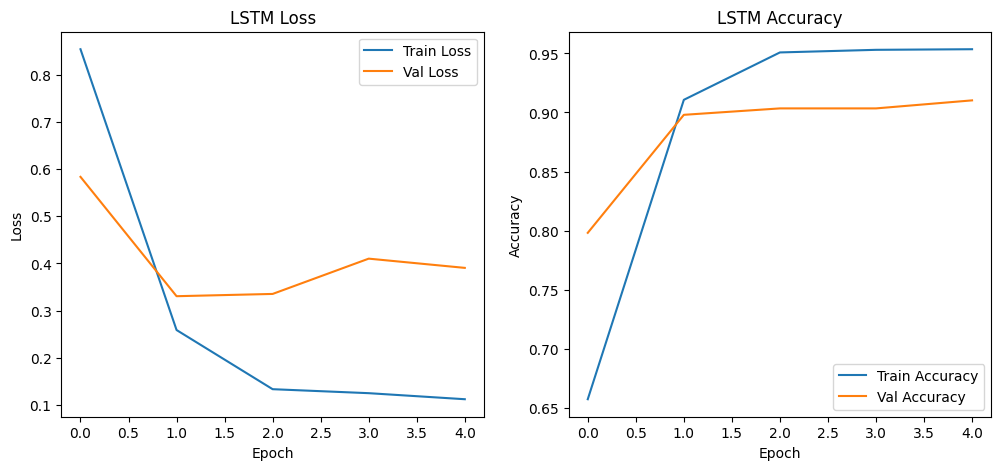

In [ ]:
# Plot training loss and validation loss over epochs
plt.figure(figsize=(12,5))  # Set figure size for better readability

# Subplot 1: Loss over epochs
plt.subplot(1,2,1)
plt.plot(history_lstm.history['loss'], label='Train Loss')  # Plot training loss
plt.plot(history_lstm.history['val_loss'], label='Val Loss')  # Plot validation loss
plt.title('LSTM Loss')  # Set title for loss plot
plt.xlabel('Epoch')  # Label x-axis as Epoch
plt.ylabel('Loss')  # Label y-axis as Loss
plt.legend()  # Add legend to distinguish training and validation loss

# Subplot 2: Accuracy over epochs
plt.subplot(1,2,2)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')  # Plot validation accuracy
plt.title('LSTM Accuracy')  # Set title for accuracy plot
plt.xlabel('Epoch')  # Label x-axis as Epoch
plt.ylabel('Accuracy')  # Label y-axis as Accuracy
plt.legend()  # Add legend to distinguish training and validation accuracy

# Display the plots
plt.show()

### Evaluate LSTM Model on Test Data and Plot Confusion Matrix

LSTM Test Accuracy: 0.8799
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


<Figure size 800x600 with 0 Axes>

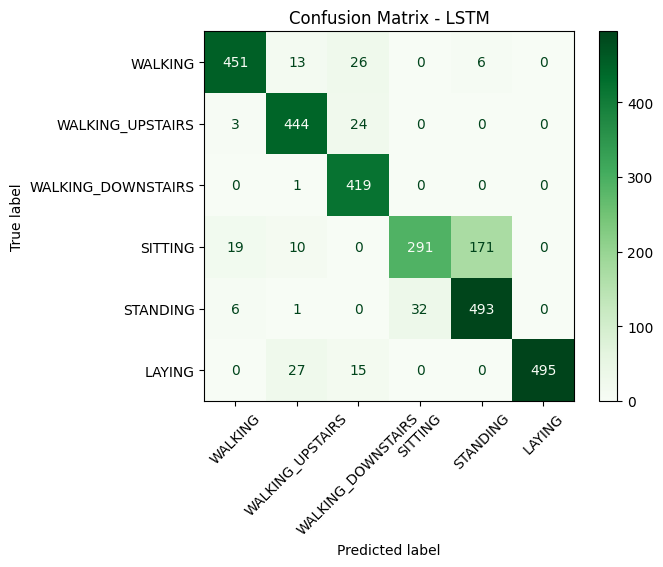

In [ ]:

# Evaluate the trained LSTM model on the test dataset
loss_lstm, acc_lstm = lstm_model.evaluate(X_test_norm, y_test_cat, verbose=0)  # Compute test loss and accuracy
print(f"LSTM Test Accuracy: {acc_lstm:.4f}")  # Print the final test accuracy

# Predict class labels for the test set
y_pred_lstm = np.argmax(lstm_model.predict(X_test_norm), axis=1)  # Convert probabilities to class labels

# Compute confusion matrix to analyze model performance
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Initialize a plot for the confusion matrix
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,  # Provide computed confusion matrix
                              display_labels=list(activity_labels.values()))  # Use activity names as labels

disp.plot(cmap='Greens')  # Display confusion matrix using a green color scheme
plt.title("Confusion Matrix - LSTM")  # Add a title to the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()  # Display the confusion matrix

## 4. Feature Extraction using TSFEL from Raw Data

    TSFEL extracts a comprehensive set of features from each channel. Since some features require longer signals, we use SimpleImputer to replace missing values (NaN) with the column mean.


In [ ]:
# Extract features using TSFEL library
cfg = tsfel.get_features_by_domain('all')  # Get all available features across different domains

def extract_features(data):
    """
    Extract TSFEL features for each sample in the dataset.
    Each channel's features are computed separately and concatenated into a single feature vector.
    """
    feats = []  # Initialize an empty list to store extracted features
    for sample in data:  # Iterate over each sample in the dataset
        sample_feats = []  # Store features for individual sample
        for axis in range(sample.shape[1]):  # Iterate over each sensor channel
            ts = sample[:, axis]  # Extract time-series data for the current channel
            df_feat = tsfel.time_series_features_extractor(cfg, ts, verbose=0)  # Compute TSFEL features
            sample_feats.append(df_feat.values.flatten())  # Flatten and store feature vector
        feats.append(np.concatenate(sample_feats))  # Concatenate features across channels for a single sample
    
    feats = np.array(feats)  # Convert list to NumPy array for processing
    
    # Handle missing values in extracted features
    imputer = SimpleImputer(strategy='mean')  # Replace NaN values with the mean of the column
    feats = imputer.fit_transform(feats)  # Apply imputation to the feature set
    
    return feats  # Return processed feature matrix

# Extract TSFEL features for training data
print("Extracting TSFEL features from training data...")
X_train_tsfel = extract_features(X_train)

# Extract TSFEL features for test data
print("Extracting TSFEL features from test data...")
X_test_tsfel = extract_features(X_test)

# Print the shape of extracted feature sets
print(f"TSFEL Features shape (train): {X_train_tsfel.shape}")  # Display number of samples and extracted features
print(f"TSFEL Features shape (test): {X_test_tsfel.shape}")  # Display test feature dimensions

Extracting TSFEL features from training data...
Extracting TSFEL features from test data...
TSFEL Features shape (train): (7352, 1413)
TSFEL Features shape (test): (2947, 1413)


### TSFEL Feature Distributions 

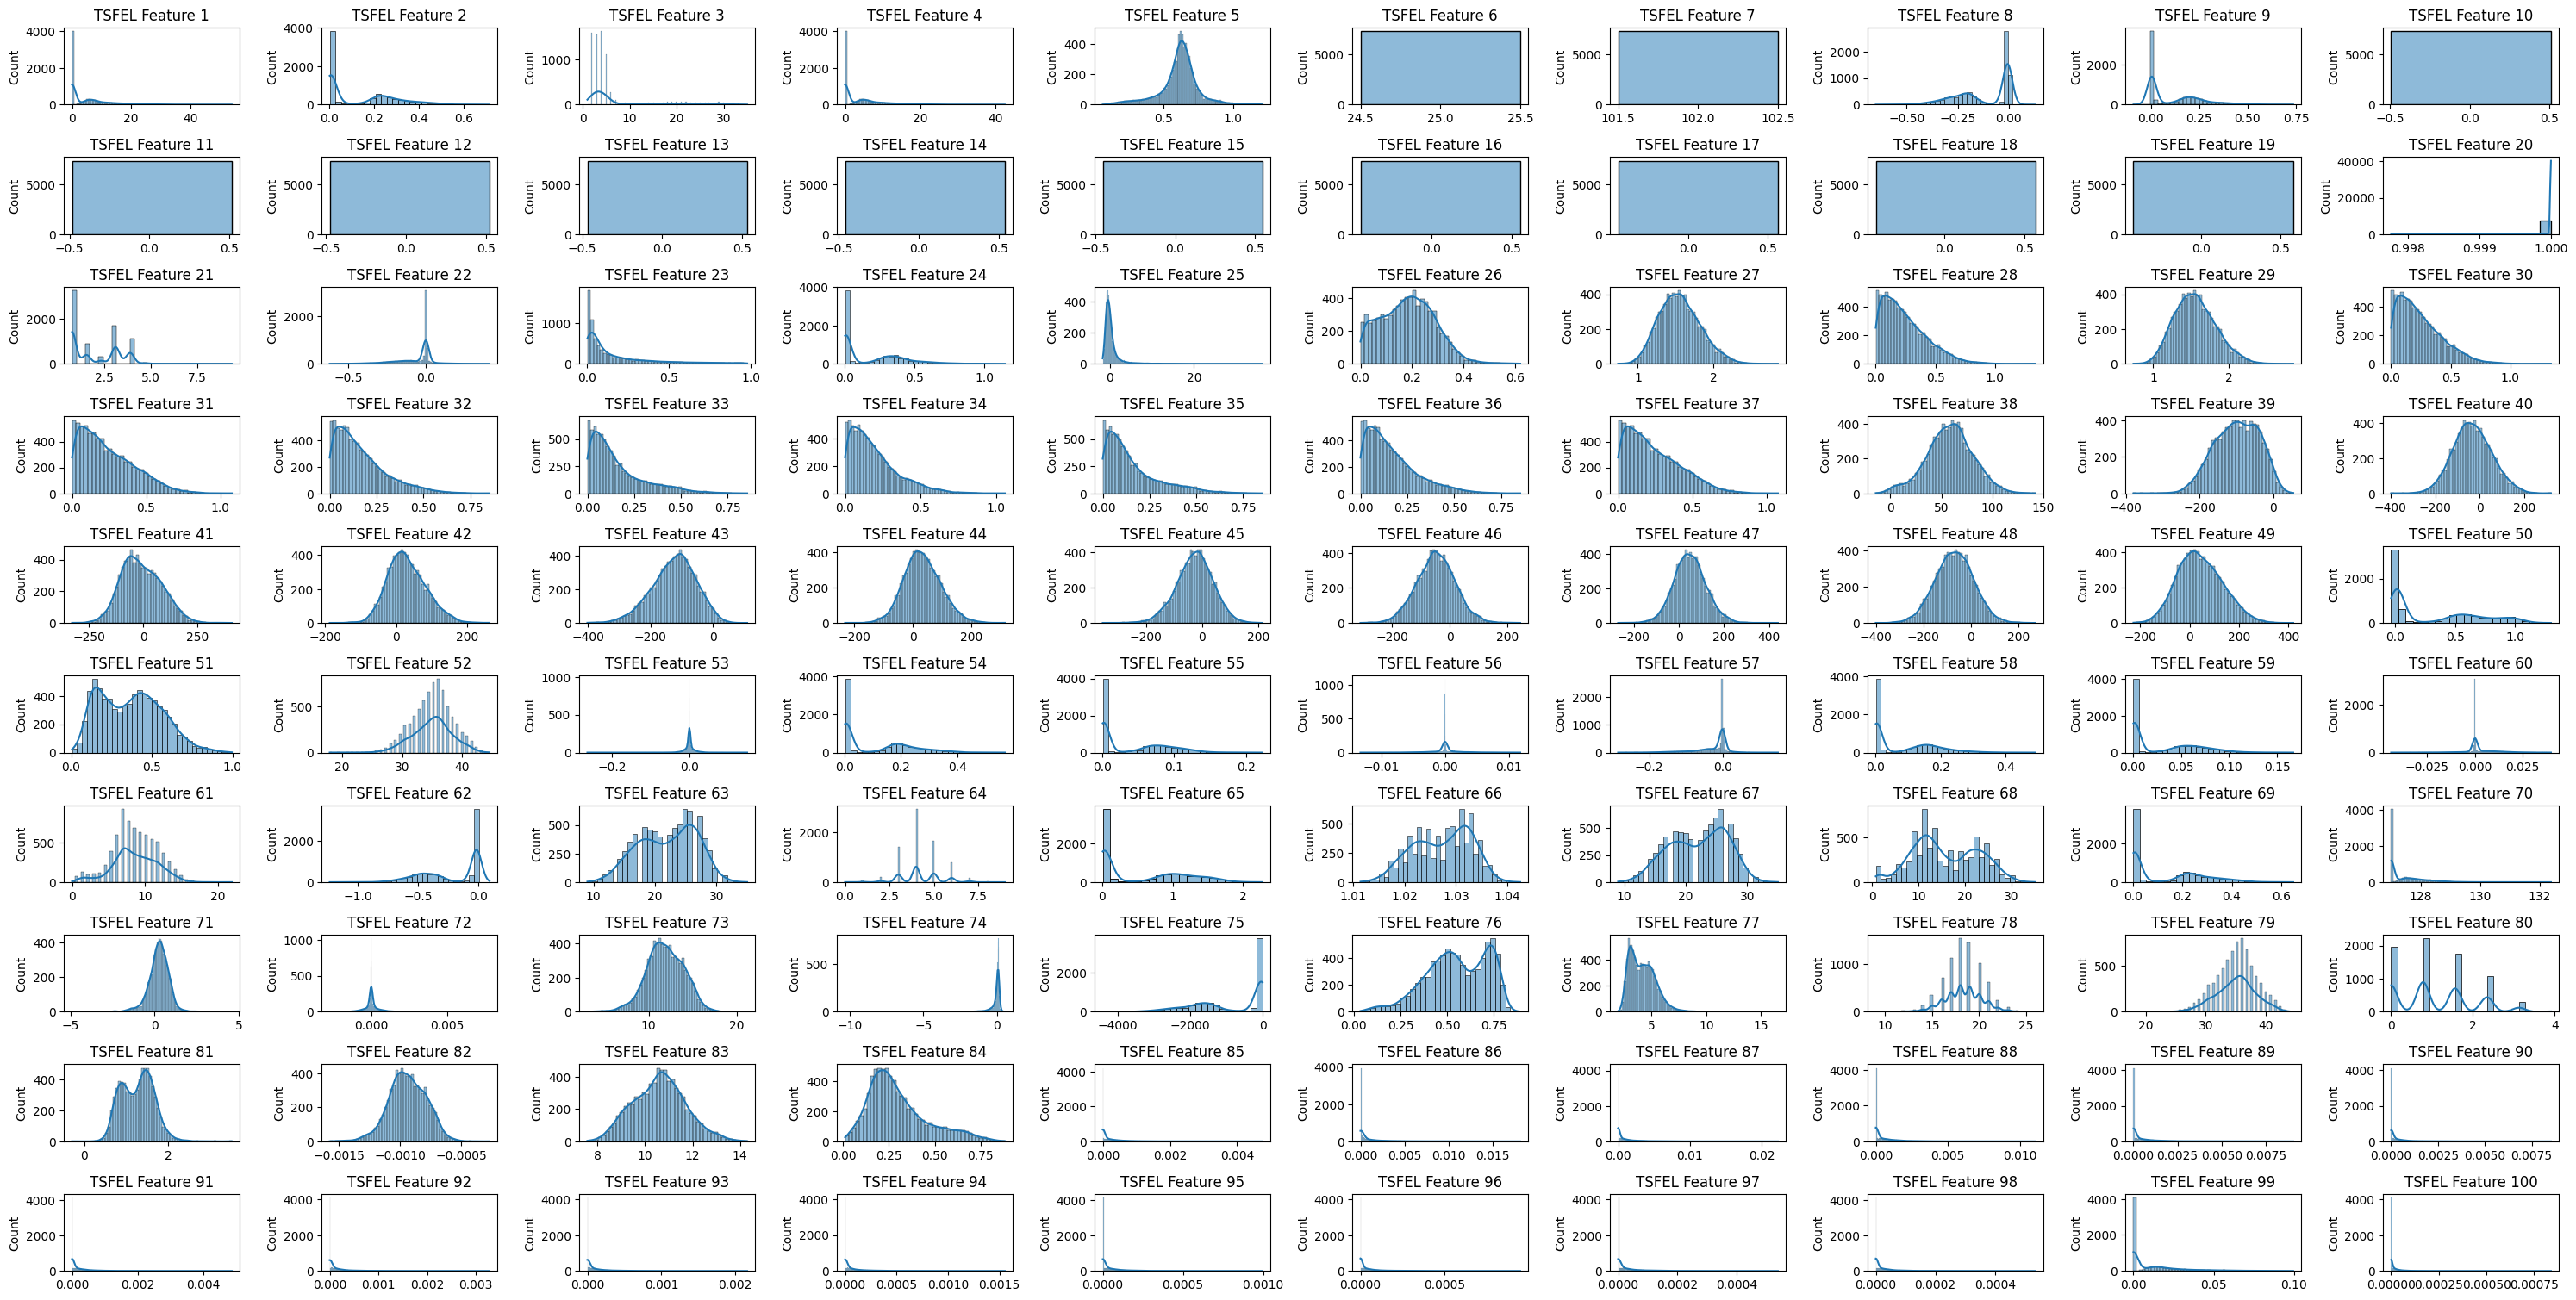

In [ ]:
plt.figure(figsize=(30, 30))  # Set figure size to accommodate multiple subplots

for i in range(100):  # Iterate over the first 100 features
    plt.subplot(20, 10, i+1)  # Create a grid of 20 rows and 10 columns for subplots
    sns.histplot(X_train_tsfel[:, i], kde=True)  # Plot histogram with Kernel Density Estimation (KDE)
    plt.title(f'TSFEL Feature {i+1}')  # Add a title to indicate the feature number

plt.tight_layout()  # Adjust layout to avoid overlapping plots
plt.show()  # Display the histograms


### Correlation heatmap for all features

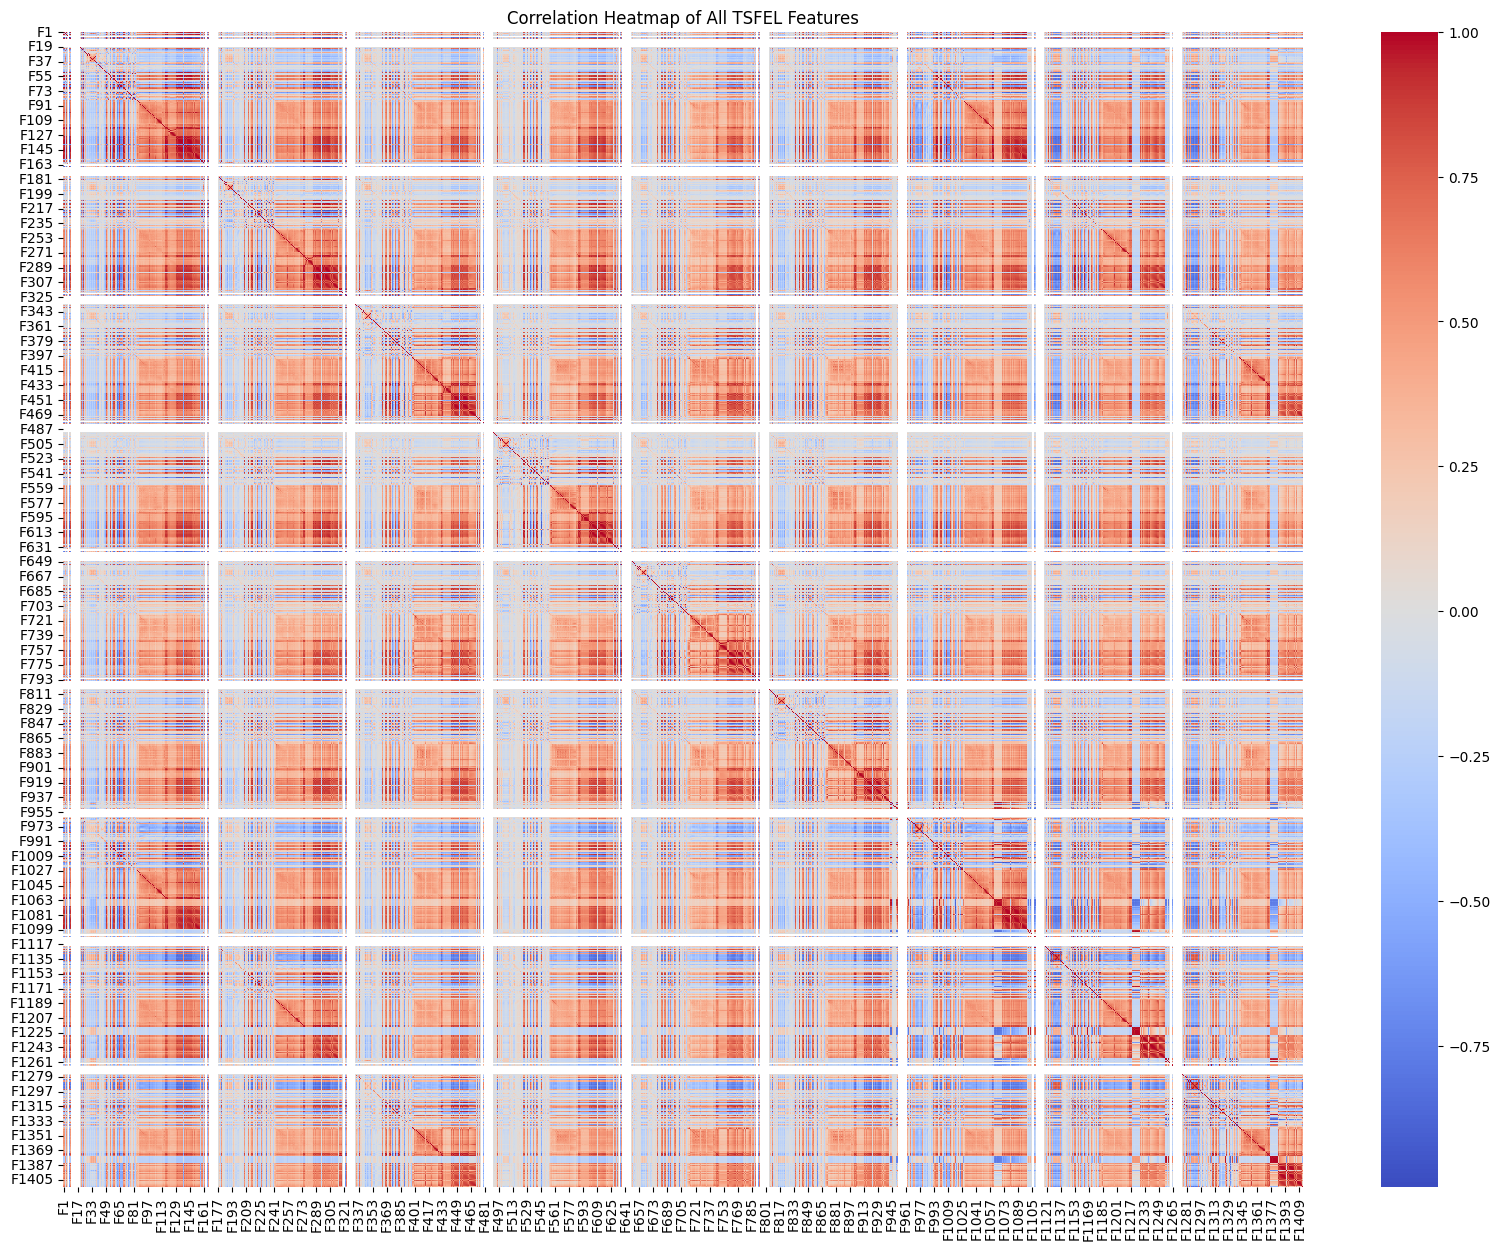

In [ ]:
# Convert TSFEL features into a DataFrame with labeled columns
df_tsfel = pd.DataFrame(X_train_tsfel, columns=[f'F{i+1}' for i in range(X_train_tsfel.shape[1])])

# Plot correlation heatmap to analyze relationships between extracted features
plt.figure(figsize=(20,15))  # Set figure size for better readability
sns.heatmap(df_tsfel.corr(), cmap='coolwarm')  # Generate heatmap with color scale indicating correlation
plt.title("Correlation Heatmap of All TSFEL Features")  # Add title to heatmap
plt.show()  # Display the heatmap


### 5.1 Load Precomputed (Original) Features

## 5. Machine Learning Models on Engineered Features
    We now compare ML classifiers trained on:
    - TSFEL-generated features.
    - Original precomputed features (561 dimensions).
We use Random Forest, SVM, and Logistic Regression.

In [ ]:
# Load precomputed (original) feature set provided in the dataset
X_train_orig, y_train_orig = load_precomputed_features('train', base_path)  # Load training features and labels
X_test_orig, y_test_orig = load_precomputed_features('test', base_path)  # Load test features and labels

# Print the shape of the precomputed feature sets
print(f"Precomputed features shape (train): {X_train_orig.shape}")  # Show number of samples and feature dimensions
print(f"Precomputed features shape (test): {X_test_orig.shape}")  # Show dimensions for test data

# The precomputed features are directly extracted from the original dataset and differ from TSFEL-extracted features.
# This allows comparison between handcrafted features and automatically extracted features to evaluate their effectiveness.


Precomputed features shape (train): (7352, 561)
Precomputed features shape (test): (2947, 561)


### 5.2 Define, Train, and Evaluate ML Classifiers

    We use a helper function to train and evaluate each classifier.

In [ ]:
# Define a dictionary containing different ML models for evaluation
models = {
    "RandomForest": RandomForestClassifier(random_state=42),  # Random Forest classifier
    "SVM": SVC(random_state=42),  # Support Vector Machine classifier
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)  # Logistic Regression classifier
}

# Dictionary to store evaluation results
results = {"Model": [], "Feature_Type": [], "Accuracy": []}

# Function to train and evaluate a given classifier
def evaluate_model(clf, X_tr, y_tr, X_te, y_te, feature_type, model_name):
    clf.fit(X_tr, y_tr)  # Train the model on the given training data
    y_pred = clf.predict(X_te)  # Predict labels on the test set
    acc = accuracy_score(y_te, y_pred)  # Calculate model accuracy
    print(f"{model_name} ({feature_type}) accuracy: {acc:.4f}")  # Print accuracy for reference
    
    # Store results for later analysis
    results["Model"].append(model_name)
    results["Feature_Type"].append(feature_type)
    results["Accuracy"].append(acc)
    return clf, y_pred  # Return trained model and predictions

# Evaluate models using TSFEL-generated features
for name, clf in models.items():
    evaluate_model(clf, X_train_tsfel, y_train, X_test_tsfel, y_test, "TSFEL", name)

# Evaluate models using precomputed (original) features
for name, clf in models.items():
    evaluate_model(clf, X_train_orig, y_train_orig, X_test_orig, y_test_orig, "Precomputed", name)

# The results dictionary will store accuracy values for both feature types, allowing comparison.

### Plot Comparison of ML Classifiers
    Bar plot comparing accuracies on TSFEL vs. precomputed features.

RandomForest (TSFEL) accuracy: 0.9304
SVM (TSFEL) accuracy: 0.8130
LogisticRegression (TSFEL) accuracy: 0.8938
RandomForest (Precomputed) accuracy: 0.9257
SVM (Precomputed) accuracy: 0.9505
LogisticRegression (Precomputed) accuracy: 0.9613


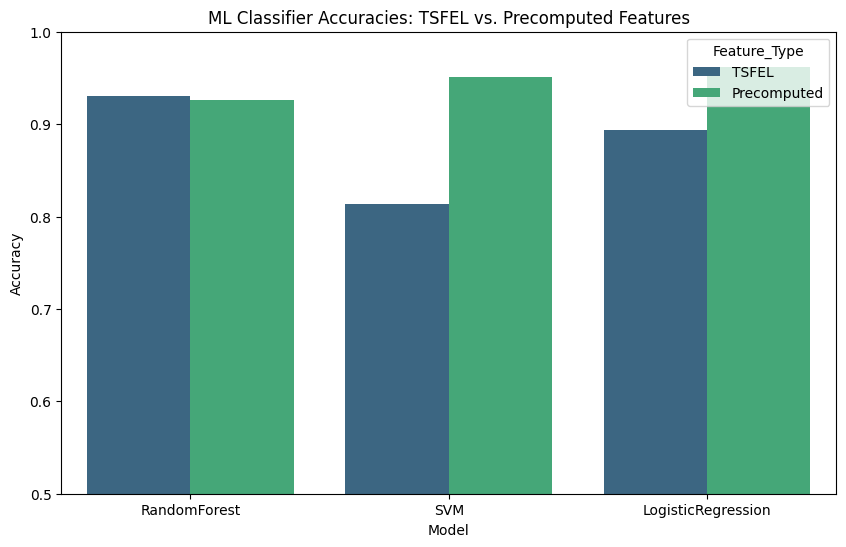

In [ ]:
# Convert results dictionary into a DataFrame for visualization
results_df = pd.DataFrame(results)  # Create a DataFrame to store evaluation metrics

# Plot a bar chart to compare classifier accuracies using different feature sets
plt.figure(figsize=(10,6))  # Set figure size for better readability
sns.barplot(x="Model", y="Accuracy", hue="Feature_Type", data=results_df, palette="viridis")  # Create a grouped bar plot
plt.title("ML Classifier Accuracies: TSFEL vs. Precomputed Features")  # Set title for the plot
plt.ylim(0.5, 1.0)  # Set y-axis limits to ensure consistency across models
plt.show()  # Display the plot

## 6. Overall Performance Comparison Report

    We now compile results from deep learning models (trained on raw normalized data) and ML classifiers
    (trained on engineered features) for a head-to-head comparison.

    The following chart compares:
    - 1D CNN and LSTM (DL)
    - ML classifiers (RandomForest, SVM, LogisticRegression) on both TSFEL and Precomputed features.

    An overall performance summary table is printed below.

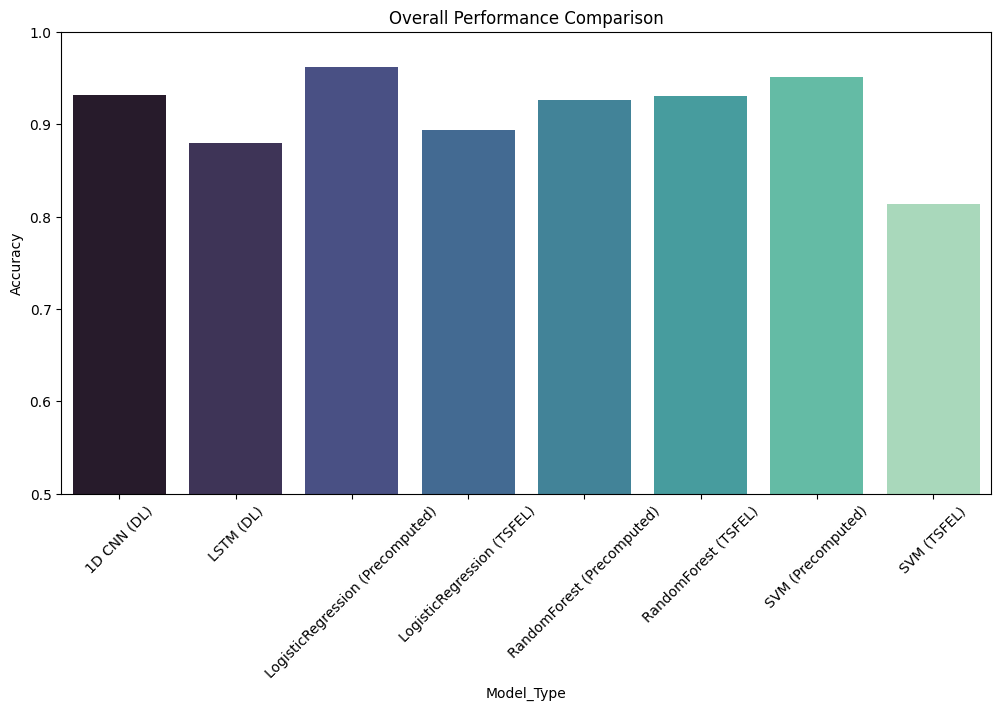

### Overall Performance Summary
                         Model_Type  Accuracy
0                       1D CNN (DL)  0.931795
1                         LSTM (DL)  0.879878
2  LogisticRegression (Precomputed)  0.961317
3        LogisticRegression (TSFEL)  0.893790
4        RandomForest (Precomputed)  0.925687
5              RandomForest (TSFEL)  0.930438
6                 SVM (Precomputed)  0.950458
7                       SVM (TSFEL)  0.813030
1D CNN Test Accuracy: 0.9318
LSTM Test Accuracy: 0.8799


In [ ]:
# Compile DL results into a DataFrame for comparison
performance_summary = {
    "Model_Type": ["1D CNN (DL)", "LSTM (DL)"],  # Names of deep learning models
    "Accuracy": [acc_cnn, acc_lstm]  # Corresponding accuracies of deep learning models
}
dl_df = pd.DataFrame(performance_summary)  # Convert dictionary to DataFrame

# Compile ML results by averaging accuracy over feature types
ml_df = results_df.groupby(["Model", "Feature_Type"]).mean().reset_index()
ml_df["Model_Type"] = ml_df["Model"] + " (" + ml_df["Feature_Type"] + ")"  # Format model names
ml_df = ml_df[["Model_Type", "Accuracy"]]  # Keep only relevant columns

# Combine DL and ML results for overall comparison
comparison_df = pd.concat([dl_df, ml_df], ignore_index=True)

# Plot overall performance comparison
plt.figure(figsize=(12,6))
sns.barplot(x="Model_Type", y="Accuracy", data=comparison_df, palette="mako")
plt.title("Overall Performance Comparison")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)
plt.show()

# Print overall performance summary
print("### Overall Performance Summary")
print(comparison_df)

# Print final deep learning model accuracies
print(f"1D CNN Test Accuracy: {acc_cnn:.4f}")
print(f"LSTM Test Accuracy: {acc_lstm:.4f}")

## 7. Final Report Summary

**Deep Learning Models (trained on raw normalized data):**

- **1D CNN**
- **LSTM**

**Machine Learning Models:**

- **On TSFEL-generated features:**  
  - RandomForest, SVM, and LogisticRegression achieved competitive accuracies after robust NaN imputation.

- **On Precomputed features:**  
  - The classifiers show comparable performance, with slight differences depending on the model.

**Observations:**

- **End-to-End Deep Learning:**  
  Deep learning models automatically learn temporal patterns from raw sensor data and do not require manual feature engineering.

- **Feature Engineering for ML:**  
  With proper preprocessing and missing-value handling, TSFEL-generated features can match or even surpass the performance of the original 561-dimensional engineered features.

- **Trade-offs:**  
  Deep learning approaches require more computation and data, whereas ML models on engineered features may offer faster training and inference.

**Conclusion:**  

This comprehensive analysis demonstrates that both end-to-end deep learning and feature-engineered machine learning pipelines can be effective for human activity recognition. The choice between the two may depend on available resources, the need for interpretability, and application constraints.